In [2]:
# Import librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from dask import bag, diagnostics
import cv2
import skopt
import plotly_express as px
from skimage import io, color, exposure, transform, img_as_float32
import skimage

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
from tune_sklearn import TuneSearchCV, TuneGridSearchCV

import umap

# Première partie : Images non-segmentées

In [105]:
# Import et affichage des 3 premières lignes du Dataframe avec images brutes
df = pd.read_csv("dataset.csv")
df.head(3)

,img_path,classes,sub_classes
0,C:\Users\lebre\Documents\Jupyter Notebook\PyBl...,basophil,BA
1,C:\Users\lebre\Documents\Jupyter Notebook\PyBl...,basophil,BA
2,C:\Users\lebre\Documents\Jupyter Notebook\PyBl...,basophil,BA


In [3]:
# Chargement des images et redimensionnement des outliers

def load_image(filename: str,  as_gray: bool = False, rescale: float = None) -> np.ndarray:
    '''
    load images from path
    
    Args:
    - filename: str, path
    - as_gray: bool, choose to import as gray
    
    return loaded image as np.array
    '''
    
    if as_gray:
        image = cv2.imread(filename, 0)
        image = cv2.resize(image, (256, 256))
        
    else:
        image = cv2.imread(filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256))
        
    if rescale: image = transform.rescale(image, rescale, anti_aliasing=True) # réduction de dimension
    
    return image

In [107]:
# Chargement des images en nuances de gris
dfile_bag = bag.from_sequence(df.img_path.to_list()).map(load_image, as_gray=True, rescale=0.5)
with diagnostics.ProgressBar():
    images = np.array(dfile_bag.compute())
images_flat = images.reshape(images.shape[0], -1)

[########################################] | 100% Completed | 35.15 s


In [108]:
images_flat.shape

(16891, 16384)

In [109]:
# Label encoder
le = preprocessing.LabelEncoder()
target = le.fit_transform(df.classes)
le.classes_

array(['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte',
       'monocyte', 'neutrophil', 'platelet'], dtype=object)

In [110]:
# Modèle UMAP

mapper = umap.UMAP(n_neighbors=5, random_state=42, n_jobs=6, n_components=500).fit(images_flat)
embedding = mapper.transform(images_flat)

In [111]:
plot_df = pd.DataFrame(df.classes)
plot_df['X_UMAP'] = embedding[:, 0]
plot_df['Y_UMAP'] = embedding[:, 1]

In [126]:
# plot_df.to_csv("plot_UMAP_2d.csv")

In [124]:
fig_2d = px.scatter(data_frame = plot_df, x='X_UMAP', y='Y_UMAP', color=df.classes, labels={'color': 'classes'})
fig_2d.update_traces(marker_size=2)
fig_2d.show()

On remarque que les plaquettes (PLATELET) se détachent du reste des cellules qui sont regroupées de façon plus homogène. On peut donc s'attendre à ce que le modèle ait plus de facilité à prédire cette classe.

In [85]:
# Séparation des données UMAP en jeux d'entraînement et de test
X_train_umap, X_test_umap, y_train_umap, y_test_umap = train_test_split(embedding, target,
                                                   train_size = 0.8,
                                                   random_state = 42)

In [4]:
# Optimisation des paramètres

def best_model_Ray_bayes(X_train, y_train, name, model):    
    '''run gridsearchCV pipeline with bayesian method on models
    Args:
        -model: initiated model 
        -name : name of model as str
    return list of best estimator and table of results
    '''

    best_model_stack = list()
    results_cv = dict()
    
    def grid_csv(params, early_stopping=False):

        GSCV = TuneSearchCV(model, params, 
                            search_optimization='bayesian',
                            n_trials=7,
                            early_stopping=early_stopping,
                            max_iters=10,
                            scoring = 'accuracy',
                            loggers=['csv'],
                            cv = 5, n_jobs=7, verbose=1)

        best_clf = GSCV.fit(X_train, y_train)

        best_hyperparams = best_clf.best_params_
        best_score = best_clf.best_score_
        estimator = best_clf.best_estimator_
        print(f'Mean cross-validated accuracy score of the best_estimator:{best_score:.3f}')
        print(f'with {best_hyperparams} for {estimator}')
        table = best_clf.cv_results_
        results_cv[name] = table

        return estimator
        

    if name == 'LR':
        params = {'C' : tuple([0.001, 0.01, 0.1, 1.]),
                 'penalty' : tuple(['l1', 'l2'])} 
        best_model_stack.append(grid_csv(params))
              
    if name == 'KNN':
        params = {'n_neighbors' : tuple(np.arange(5, 100, 5)),
                 'weights' : tuple(['uniform', 'distance']),
                 'algorithm' : tuple(['ball_tree', 'kd_tree', 'brute', 'auto'])} 
        best_model_stack.append(grid_csv(params))
    
    if name == 'SVM':
        params = {'kernel' : tuple(['linear', 'poly', 'rbf', 'sigmoid']),
                 'C' : tuple(np.arange(0.01, 1, 0.02))} 
        best_model_stack.append(grid_csv(params))


    if name == 'RF': 
        params = {'n_estimators' : tuple(np.arange(5, 200, 10)),
                  'max_features' : tuple(['auto', 'sqrt', 'log2']),
                  'max_depth' : tuple(np.arange(3, 15, 1)),
                  'min_weight_fraction_leaf': tuple(np.arange(0, 0.6, 0.2))
                 } 
        best_model_stack.append(grid_csv(params))

        
    return best_model_stack, results_cv

In [87]:
model_GSCV = {}
model_GSCV['LR'] = LogisticRegression(class_weight="balanced", solver="liblinear")
model_GSCV['KNN'] = KNeighborsClassifier()
model_GSCV['SVM'] = SVC()
model_GSCV['RF'] = RandomForestClassifier(class_weight='balanced')

In [5]:
def plot_conf_mat(y_true, y_pred, name):
    data = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(data, columns=le.classes_, index = le.classes_)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (6,4))
    sns.set(font_scale=0.8)
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 8}, fmt='g')
    plt.title(name)
    plt.show()
    
    print(classification_report(y_true, y_pred, target_names = le.classes_))


In [89]:
results_best_model_bayes = {}
scoring_bayes = {}

for name, model in model_GSCV.items():
    scores = best_model_Ray_bayes(X_train_umap, y_train_umap, name, model)
    results_best_model_bayes[name] = scores[0][0]

2023-03-24 14:40:17,128	INFO tune.py:798 -- Total run time: 122.64 seconds (122.62 seconds for the tuning loop).


Mean cross-validated accuracy score of the best_estimator:0.751
with {'n_estimators': 155, 'max_features': 'auto', 'max_depth': 12, 'min_weight_fraction_leaf': 0.0} for RandomForestClassifier(class_weight='balanced', max_depth=12, n_estimators=155)


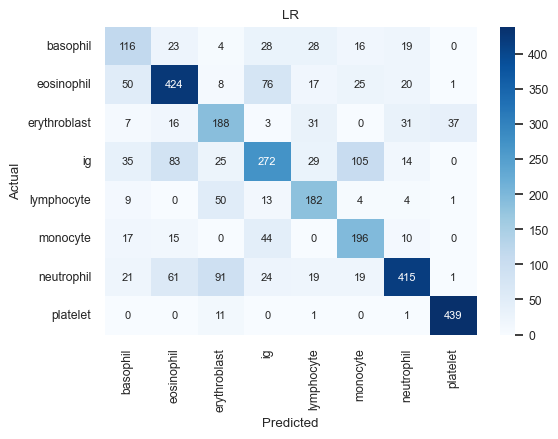

              precision    recall  f1-score   support

    basophil       0.45      0.50      0.47       234
  eosinophil       0.68      0.68      0.68       621
erythroblast       0.50      0.60      0.54       313
          ig       0.59      0.48      0.53       563
  lymphocyte       0.59      0.69      0.64       263
    monocyte       0.54      0.70      0.61       282
  neutrophil       0.81      0.64      0.71       651
    platelet       0.92      0.97      0.94       452

    accuracy                           0.66      3379
   macro avg       0.64      0.66      0.64      3379
weighted avg       0.67      0.66      0.66      3379



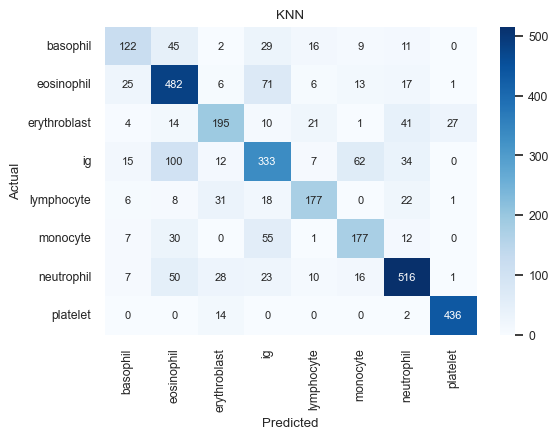

              precision    recall  f1-score   support

    basophil       0.66      0.52      0.58       234
  eosinophil       0.66      0.78      0.71       621
erythroblast       0.68      0.62      0.65       313
          ig       0.62      0.59      0.60       563
  lymphocyte       0.74      0.67      0.71       263
    monocyte       0.64      0.63      0.63       282
  neutrophil       0.79      0.79      0.79       651
    platelet       0.94      0.96      0.95       452

    accuracy                           0.72      3379
   macro avg       0.71      0.70      0.70      3379
weighted avg       0.72      0.72      0.72      3379



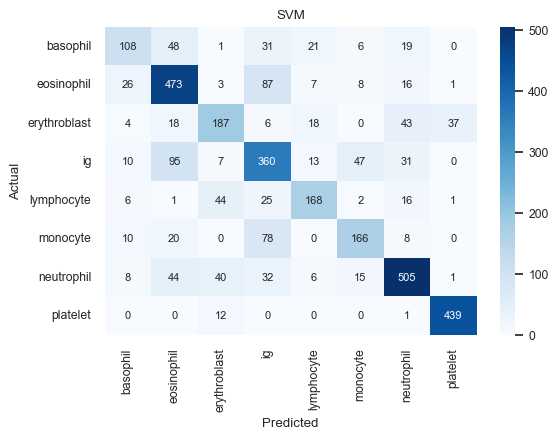

              precision    recall  f1-score   support

    basophil       0.63      0.46      0.53       234
  eosinophil       0.68      0.76      0.72       621
erythroblast       0.64      0.60      0.62       313
          ig       0.58      0.64      0.61       563
  lymphocyte       0.72      0.64      0.68       263
    monocyte       0.68      0.59      0.63       282
  neutrophil       0.79      0.78      0.78       651
    platelet       0.92      0.97      0.94       452

    accuracy                           0.71      3379
   macro avg       0.70      0.68      0.69      3379
weighted avg       0.71      0.71      0.71      3379



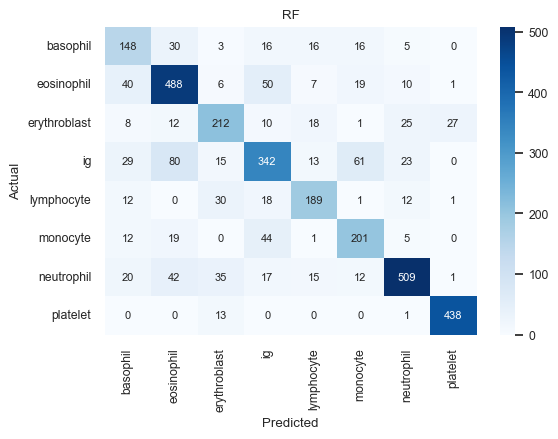

              precision    recall  f1-score   support

    basophil       0.55      0.63      0.59       234
  eosinophil       0.73      0.79      0.76       621
erythroblast       0.68      0.68      0.68       313
          ig       0.69      0.61      0.65       563
  lymphocyte       0.73      0.72      0.72       263
    monocyte       0.65      0.71      0.68       282
  neutrophil       0.86      0.78      0.82       651
    platelet       0.94      0.97      0.95       452

    accuracy                           0.75      3379
   macro avg       0.73      0.74      0.73      3379
weighted avg       0.75      0.75      0.75      3379



In [90]:
for name, model in results_best_model_bayes.items():
    y_pred_umap = model.predict(X_test_umap)
    plot_conf_mat(y_test_umap, y_pred_umap, name)

# Deuxième partie : Images segmentées

In [24]:
# Import et affichage des 3 premières lignes du Dataframe avec images segmentées
df2 = pd.read_csv("dataset_imgs_seg.csv")
df2.head(3)

,img_path,classes,sub_classes
0,C:\Users\lebre\Documents\Jupyter Notebook\PyBl...,basophil,BA
1,C:\Users\lebre\Documents\Jupyter Notebook\PyBl...,basophil,BA
2,C:\Users\lebre\Documents\Jupyter Notebook\PyBl...,basophil,BA


In [25]:
# Chargement des images segmentées en nuances de gris
dfile_bag = bag.from_sequence(df2.img_path.to_list()).map(load_image, as_gray=True, rescale=0.5)
with diagnostics.ProgressBar():
    images = np.array(dfile_bag.compute())
images_flat = images.reshape(images.shape[0], -1)

[########################################] | 100% Completed | 13.84 s


In [26]:
images_flat.shape

(16891, 16384)

In [27]:
# Label encoder
le = preprocessing.LabelEncoder()
target = le.fit_transform(df2.classes)
le.classes_

array(['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte',
       'monocyte', 'neutrophil', 'platelet'], dtype=object)

In [56]:
# Modèle UMAP

mapper = umap.UMAP(n_neighbors=5, random_state=42, n_jobs=6, n_components=500).fit(images_flat)
embedding = mapper.transform(images_flat)

In [57]:
plot_df = pd.DataFrame(df2.classes)
plot_df['X_UMAP'] = embedding[:, 0]
plot_df['Y_UMAP'] = embedding[:, 1]

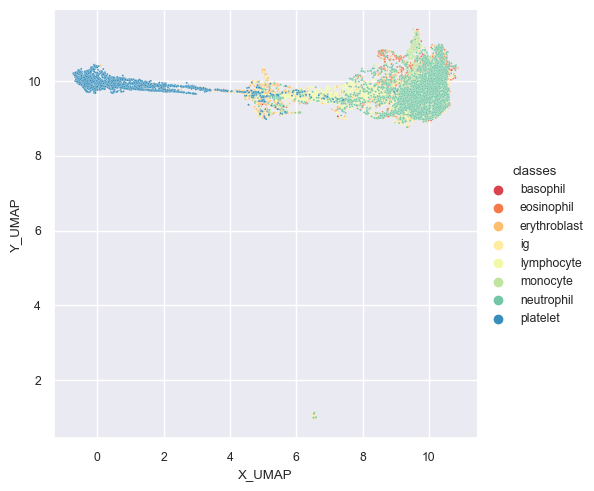

In [58]:
sns.relplot(x='X_UMAP', y='Y_UMAP', hue='classes', data=plot_df,
                s=2, palette='Spectral');

In [52]:
# Séparation des données UMAP en jeux d'entraînement et de test
X_train_umap, X_test_umap, y_train_umap, y_test_umap = train_test_split(embedding, target,
                                                   train_size = 0.8,
                                                   random_state = 42)

In [53]:
model_GSCV = {}
model_GSCV['LR'] = LogisticRegression(class_weight="balanced", solver="liblinear")
model_GSCV['KNN'] = KNeighborsClassifier()

model_GSCV['RF'] = RandomForestClassifier(class_weight='balanced')

In [54]:
results_best_model_bayes = {}
scoring_bayes = {}

for name, model in model_GSCV.items():
    scores = best_model_Ray_bayes(X_train_umap, y_train_umap, name, model)
    results_best_model_bayes[name] = scores[0][0]

2023-03-25 22:16:19,754	INFO tune.py:798 -- Total run time: 13.75 seconds (13.72 seconds for the tuning loop).


Mean cross-validated accuracy score of the best_estimator:0.507
with {'n_estimators': 105, 'max_features': 'log2', 'max_depth': 14, 'min_weight_fraction_leaf': 0.0} for RandomForestClassifier(class_weight='balanced', max_depth=14,
                       max_features='log2', n_estimators=105)


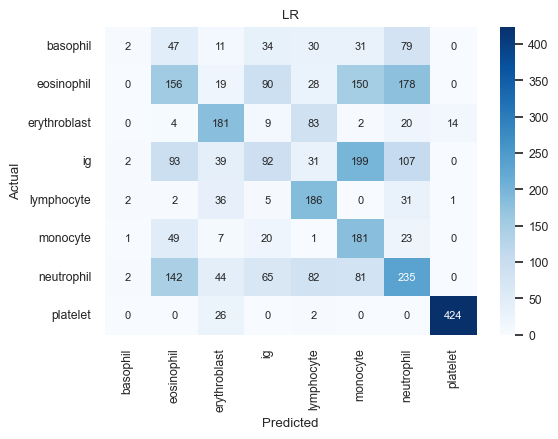

              precision    recall  f1-score   support

    basophil       0.22      0.01      0.02       234
  eosinophil       0.32      0.25      0.28       621
erythroblast       0.50      0.58      0.54       313
          ig       0.29      0.16      0.21       563
  lymphocyte       0.42      0.71      0.53       263
    monocyte       0.28      0.64      0.39       282
  neutrophil       0.35      0.36      0.35       651
    platelet       0.97      0.94      0.95       452

    accuracy                           0.43      3379
   macro avg       0.42      0.46      0.41      3379
weighted avg       0.42      0.43      0.41      3379



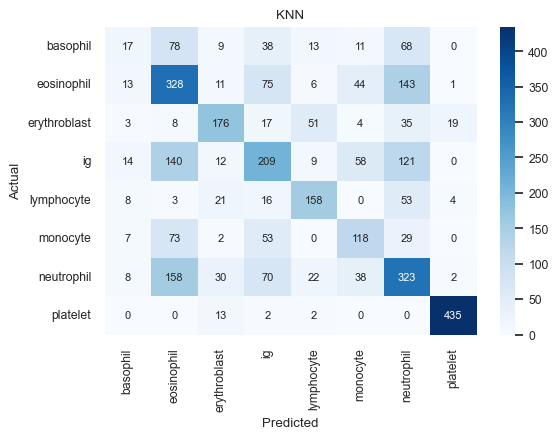

              precision    recall  f1-score   support

    basophil       0.24      0.07      0.11       234
  eosinophil       0.42      0.53      0.47       621
erythroblast       0.64      0.56      0.60       313
          ig       0.44      0.37      0.40       563
  lymphocyte       0.61      0.60      0.60       263
    monocyte       0.43      0.42      0.43       282
  neutrophil       0.42      0.50      0.45       651
    platelet       0.94      0.96      0.95       452

    accuracy                           0.52      3379
   macro avg       0.52      0.50      0.50      3379
weighted avg       0.52      0.52      0.51      3379



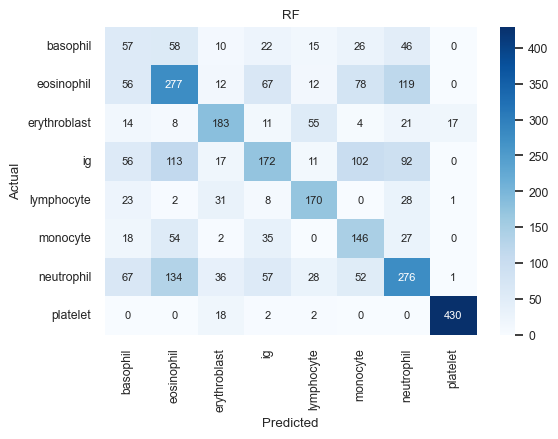

              precision    recall  f1-score   support

    basophil       0.20      0.24      0.22       234
  eosinophil       0.43      0.45      0.44       621
erythroblast       0.59      0.58      0.59       313
          ig       0.46      0.31      0.37       563
  lymphocyte       0.58      0.65      0.61       263
    monocyte       0.36      0.52      0.42       282
  neutrophil       0.45      0.42      0.44       651
    platelet       0.96      0.95      0.95       452

    accuracy                           0.51      3379
   macro avg       0.50      0.51      0.50      3379
weighted avg       0.51      0.51      0.51      3379



In [55]:
for name, model in results_best_model_bayes.items():
    y_pred_umap = model.predict(X_test_umap)
    plot_conf_mat(y_test_umap, y_pred_umap, name)